In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, DenseNet201, VGG16, VGG19, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import HeUniform

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, roc_curve

import sklearn
from sklearn.model_selection import train_test_split
import os
import numpy as np
import os
import shutil
import random
from matplotlib import pyplot as plt
import matplotlib

print("\nLibraries\n-----------------------------")
print(f"Tensorflow: {tf.__version__}")
print(f"Scikit Learn: {sklearn.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")


Libraries
-----------------------------
Tensorflow: 2.12.0
Scikit Learn: 1.2.1
Numpy: 1.22.1
Matplotlib: 3.7.0


In [2]:
def count_files_in_directory(directory_path):
    total_files = 0

    for root, _, files in os.walk(directory_path):
        total_files += len(files)

    return total_files

In [3]:
def create_test_set(source_dir, test_dir, class_names, test_percent):
    os.makedirs(test_dir, exist_ok = True)
    
    for class_name in class_names:
        class_source_dir = os.path.join(source_dir, class_name)
        class_test_dir = os.path.join(test_dir, class_name)
        os.makedirs(class_test_dir, exist_ok = True)
        
        images = os.listdir(class_source_dir)
        num_images = len(images)
        num_test_images = int(test_percent * num_images)
        
        test_indices = random.sample(range(num_images), num_test_images)
        
        for index in test_indices:
            image_name = images[index]
            source_path = os.path.join(class_source_dir, image_name)
            target_path = os.path.join(class_test_dir, image_name)
            shutil.move(source_path, target_path)

In [4]:
# Define image dimensions and other parameters
img_height, img_width = 80, 400
num_classes = 3

data_dir = "./DS2/Train"
class_names = os.listdir(data_dir)

# test set
source_data_dir = "./DS2/Train"
test_data_dir = "./DS2/Testset"
valid_data_dir = "./DS2/Validset"
class_names = os.listdir(source_data_dir)

first_execution = True

if first_execution:
    create_test_set(source_data_dir, test_data_dir, class_names, 0.3)
    create_test_set(source_data_dir, valid_data_dir, class_names, 0.2)

In [5]:
datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    rescale = 1.0 / 255.00,
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input
)

data_generator = datagen.flow_from_directory(
    data_dir,
    target_size = (img_height, img_width),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True,
    classes = class_names
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
        "./DS2/Validset",
        target_size = (img_height, img_width),
        batch_size = 32,
        class_mode = 'categorical',
        shuffle = True,
        classes = class_names
)

Found 370 images belonging to 3 classes.
Found 130 images belonging to 3 classes.


In [6]:
base_model = InceptionV3(
    weights = "imagenet",
    include_top = False,
    input_shape = (img_height, img_width, 3)
)

# freeze already trained layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation = 'relu', kernel_initializer = 'uniform')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 400, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 39, 199, 32)  864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 39, 199, 32)  96         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

 batch_normalization_10 (BatchN  (None, 7, 47, 96)   288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 7, 47, 32)   96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 7, 47, 64)    0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 7, 47, 64)    0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_20 (Conv2D)             (None, 7, 47, 48)    13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 7, 47, 96)    55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 7, 47, 48)   144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 7, 47, 96)   288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_34 (Conv2D)             (None, 3, 23, 128)   98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 3, 23, 128)  384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 3, 23, 128)   0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 3, 23, 128)   114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 3, 23, 160)   0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 3, 23, 160)   179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 3, 23, 160)  480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 3, 23, 160)   0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41

 batch_normalization_55 (BatchN  (None, 3, 23, 160)  480         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 3, 23, 160)   0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 3, 23, 160)   122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 3, 23, 160)   179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 3, 23, 160)  480         ['conv2d_51[0][0]']              
 ormalizat

 conv2d_61 (Conv2D)             (None, 3, 23, 192)   147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 3, 23, 192)   258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 3, 23, 192)  576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 3, 23, 192)  576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 3, 23, 192)  576         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 3, 23, 192)   0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 3, 23, 192)   0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 1, 11, 320)   552960      ['activation_70[0][0]']          
          

                                                                                                  
 activation_82 (Activation)     (None, 1, 11, 384)   0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 1, 11, 384)   0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 1, 11, 192)  576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 1, 11, 320)   0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 

 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 1, 11, 320)   0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 1, 11, 768)   0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 1, 11, 768)   0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activatio

In [8]:
model.compile(optimizer = SGD(learning_rate = 0.001, momentum = 0.9),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(data_generator, epochs = 100,
                    validation_data = validation_generator, verbose = 0)

### Please note that the following curves a clear example of overfitting, this is seen by a clear divergence in training (blue) and validation loss (organge curve). Curves should ideally show convergence while a small gap should exist between the two curves to wards the end of the training cycle

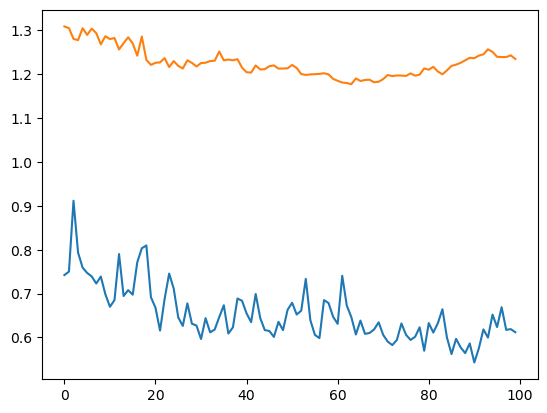

In [9]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

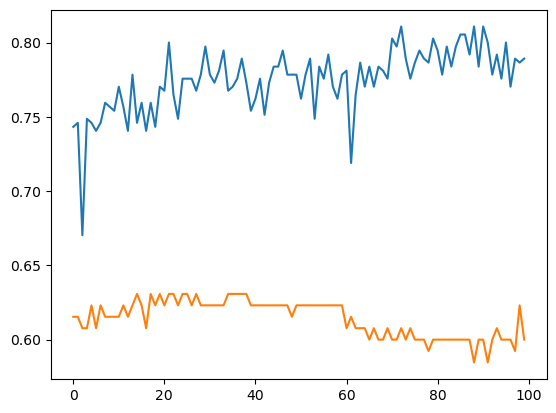

In [10]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [11]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_height, img_width),
    class_mode = 'categorical',
    batch_size = count_files_in_directory(test_data_dir),
    shuffle = False,
    classes = class_names
)

Found 194 images belonging to 3 classes.


In [12]:
real_labels = []
test_probs = []
test_labels = []
test_errors = []
batch_images, batch_labels = next(test_generator)

for individual_image in range(batch_images.shape[0]):
    single_image_array = batch_images[individual_image]
    single_image_label = batch_labels[individual_image]
    
    test_prob = model.predict(np.expand_dims(single_image_array, axis=0), verbose = 0)
    test_pred = np.argmax(test_prob)
    test_error = np.sqrt(np.mean((test_prob - single_image_label) ** 2))
    
    
    real_labels.append(single_image_label)
    test_probs.append(test_prob[0, test_pred])
    test_labels.append(test_pred)
    test_errors.append(test_error)

test_probs = np.array(test_probs).reshape(-1)
test_labels = np.array(test_labels).reshape(-1)
test_errors = np.array(test_errors).reshape(-1)

In [13]:
class_labels = []
for array in real_labels:
    class_label = np.argmax(array)
    class_labels.append(class_label)
real_labels = class_labels
indices0 = [index for index, value in enumerate(real_labels) if value == 0]
indices1 = [index for index, value in enumerate(real_labels) if value == 1]
indices2 = [index for index, value in enumerate(real_labels) if value == 2]

### Please note through both loss values and the confusion matrix that the algorithm makes many mistakes, which is a clear sign of an algorithm that is not working. This is due to the large imbalance between the classes in the dataset

In [14]:
print(f"Test Tooth Score Loss {np.mean(test_errors[indices1]) * 100:.2f}%")
print(f"Test Cut Mark Loss {np.mean(test_errors[indices0]) * 100:.2f}%")
print(f"Test Trampling Mark Loss {np.mean(test_errors[indices2]) * 100:.2f}%")
print(f"Overall Loss {np.mean(test_errors) * 100:.2f}%")

Test Tooth Score Loss 13.68%
Test Cut Mark Loss 69.61%
Test Trampling Mark Loss 65.56%
Overall Loss 60.58%


In [15]:
print(classification_report(real_labels, test_labels))
print(confusion_matrix(real_labels, test_labels))

              precision    recall  f1-score   support

           0       1.00      0.08      0.14       146
           1       0.18      0.93      0.30        30
           2       0.07      0.11      0.09        18

    accuracy                           0.21       194
   macro avg       0.42      0.37      0.18       194
weighted avg       0.79      0.21      0.16       194

[[ 11 112  23]
 [  0  28   2]
 [  0  16   2]]


In [16]:
return_files = True

if return_files:
    source_folders = ["./DS2/Testset", "./DS2/Validset"]
    destination_folder = "./DS2/Train"

    for source_folder in source_folders:
        source_path = os.path.join(source_folder, "CutMark")
        destination_path = os.path.join(destination_folder, "CutMark")

        # Move files from source subfolder to destination subfolder
        for filename in os.listdir(source_path):
            source_file = os.path.join(source_path, filename)
            destination_file = os.path.join(destination_path, filename)
            shutil.move(source_file, destination_file)

        source_path = os.path.join(source_folder, "Score")
        destination_path = os.path.join(destination_folder, "Score")

        # Move files from source subfolder to destination subfolder
        for filename in os.listdir(source_path):
            source_file = os.path.join(source_path, filename)
            destination_file = os.path.join(destination_path, filename)
            shutil.move(source_file, destination_file)

        source_path = os.path.join(source_folder, "Trampling")
        destination_path = os.path.join(destination_folder, "Trampling")

        # Move files from source subfolder to destination subfolder
        for filename in os.listdir(source_path):
            source_file = os.path.join(source_path, filename)
            destination_file = os.path.join(destination_path, filename)
            shutil.move(source_file, destination_file)

    print("Files moved successfully.")

Files moved successfully.


In [17]:
import winsound
winsound.Beep(1000, 2000)  # Beep at 1000 Hz for 200 milliseconds